# Performance Analysis for Steam Game Recommender System

Task 1: Performance Analysis and Optimization


This notebook presents the performance evaluation of a personalized recommender system developed using the Steam Video Games dataset. The dataset contains user interaction logs, including purchase and play behavior, which are used to infer preferences and build recommendation models.

In Assignment 1, several approaches were implemented:

- **Memory-based Collaborative Filtering** (User-User and Item-Item)
- **Content-Based Filtering** using TF-IDF features extracted from game titles

The primary objective of this phase is to:
- Assess the quality and limitations of each recommendation method
- Perform a detailed data cleaning and exploratory analysis
- Apply evaluation metrics such as MAE, RMSE, Precision, NDCG, MRR and MAP

This analysis provides insights into how effectively different algorithms can personalize recommendations for Steam users, especially in the presence of data sparsity, popularity bias, and cold-start problems.

## 1.0 Data Preprocessing & Cleaning

This section prepares the Steam dataset for analysis. Key tasks include:
- Assigning appropriate column names
- Removing irrelevant columns
- Handling missing values
- Removing duplicates
- Filtering the dataset for meaningful interactions
- Normalization & Encoding

### Load and Assign Column Names

In [1]:
# Import necessary libraries
import pandas as pd

# Load the dataset
df = pd.read_csv("steam-200k.csv", header=None)
df.columns = ['user_id', 'game_title', 'behavior_name', 'value', '0']

# Display the first few rows
df.head()

,user_id,game_title,behavior_name,value,0
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


#### Overview of the Dataset

The dataset contains 200,000 records of user interactions on the Steam gaming platform. Each record represents either a purchase or a playtime record of a user for a specific game.

**Columns:**
- `user_id`: Unique identifier of the user
- `game_title`: Name of the game
- `behavior_name`: Type of interaction, either 'purchase' or 'play'
- `value`: Always 1 for purchases; represents hours played for play interactions
- `0`: Unknown column

### Removing Irrelevant Columns

The original file contained an unknown column named `'0'`, which is not useful for our recommender system. It has been removed to focus on relevant features.

In [2]:
# Check the number of unique value for unknown column
print("Unique 0 values:", df['0'].nunique())

Unique 0 values: 1


In [3]:
# Drop the '0' colum
df.drop('0', axis=1, inplace=True)

# Check the result
df.head()

,user_id,game_title,behavior_name,value
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


### Handling Missing Values

This code will show how many missing values exist in each column. Ideally, the dataset should have no missing values, especially in essential columns like `user_id`, `game_title`, and `behavior_name`.

In [4]:
# Check for missing values
df.isnull().sum()

user_id          0
game_title       0
behavior_name    0
value            0
dtype: int64

### Removing duplicates

We check for and remove any duplicate user-game interactions. This ensures that each action is unique and doesn't skew the analysis.

In [5]:
# Check for duplicate rows
print("Duplicate rows:", df.duplicated().sum())

# Drop duplicates
df.drop_duplicates(inplace=True)

Duplicate rows: 707


### Filtering the Dataset for Meaningful Interactions

The dataset includes two types of user interactions: `purchase` and `play`. While purchase data provides a binary signal (purchased or not), it does not reflect how much a user enjoyed or engaged with the game. In contrast, playtime data provides a more granular measure of user interest and is therefore used for building the recommendation system in this analysis.

In [6]:
# Keep only 'play' interactions for modeling purposes
df_play = df[df['behavior_name'] == 'play'].copy()

# Reset index
df_play.reset_index(drop=True, inplace=True)

df_play.head()

,user_id,game_title,behavior_name,value
0,151603712,The Elder Scrolls V Skyrim,play,273.0
1,151603712,Fallout 4,play,87.0
2,151603712,Spore,play,14.9
3,151603712,Fallout New Vegas,play,12.1
4,151603712,Left 4 Dead 2,play,8.9


### Normalization & Encoding

Goal:
- Normalize the value column 
- Encode categorical columns (user_id, game_title, behavior_name) if needed for modeling

#### Normalization

We normalized the `value` field for rows with `play` behavior using Min-Max Scaling. This scales the hours played between 0 and 1, which is especially useful when feeding values into collaborative or content-based models.

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Apply Min-Max normalization to the playtime values
scaler = MinMaxScaler()
df_play['playtime_normalized'] = scaler.fit_transform(df_play[['value']])

df_play.head()

,user_id,game_title,behavior_name,value,playtime_normalized
0,151603712,The Elder Scrolls V Skyrim,play,273.0,0.023218
1,151603712,Fallout 4,play,87.0,0.007393
2,151603712,Spore,play,14.9,0.001259
3,151603712,Fallout New Vegas,play,12.1,0.001021
4,151603712,Left 4 Dead 2,play,8.9,0.000749


### Encode Categorical Features

#### Label Encoding

We encoded `user_id` and `game_title` into numerical form using `LabelEncoder` to make them usable in matrix-based collaborative filtering or machine learning models.

In [8]:
from sklearn.preprocessing import LabelEncoder

# Encode user_id and game_title
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

df_play['user_encoded'] = user_encoder.fit_transform(df_play['user_id'])
df_play['game_encoded'] = item_encoder.fit_transform(df_play['game_title'])

df_play.head()

,user_id,game_title,behavior_name,value,playtime_normalized,user_encoded,game_encoded
0,151603712,The Elder Scrolls V Skyrim,play,273.0,0.023218,5088,3067
1,151603712,Fallout 4,play,87.0,0.007393,5088,1162
2,151603712,Spore,play,14.9,0.001259,5088,2813
3,151603712,Fallout New Vegas,play,12.1,0.001021,5088,1163
4,151603712,Left 4 Dead 2,play,8.9,0.000749,5088,1733


In [9]:
# Save the clean version
df_play.to_csv("steam_cleaned_normalized_play.csv", index=False)

## 2.0 Exploratory Data Analysis (EDA)

This section explores the Steam dataset to extract meaningful insights into:
- User behavior
- Rating (playtime) distributions
- Item popularity

These insights support model design and evaluation in subsequent ages.
oularity)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_play = pd.read_csv("steam_cleaned_normalized_play.csv")

# Set Seaborn styling
sns.set(style="whitegrid")

### 2.1 Playtime Distribution --> Rating Distribution

Playtime (used as implicit rating) is highly skewed. Most users spend only a small number of hours, while a few play extensively. This distribution is typical for digital engagement data.

C:\Users\amarl\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


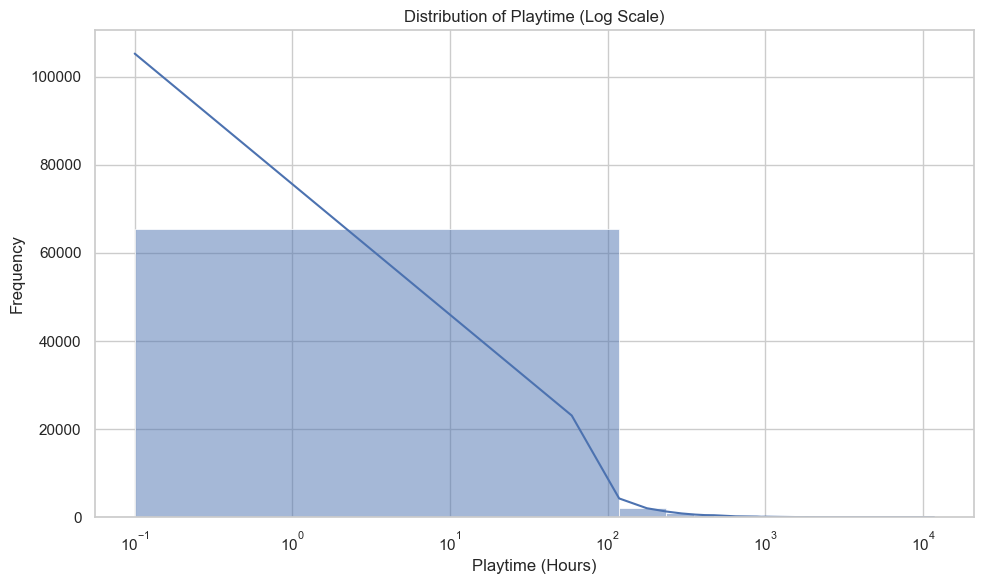

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(df_play['value'], bins=100, kde=True)
plt.xscale('log')
plt.title('Distribution of Playtime (Log Scale)')
plt.xlabel('Playtime (Hours)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### 2.2 Top 10 Most Played Games (Total Hours) --> Item Popularity

Games with the highest total playtime indicate titles with the most user engagement in terms of time spen.


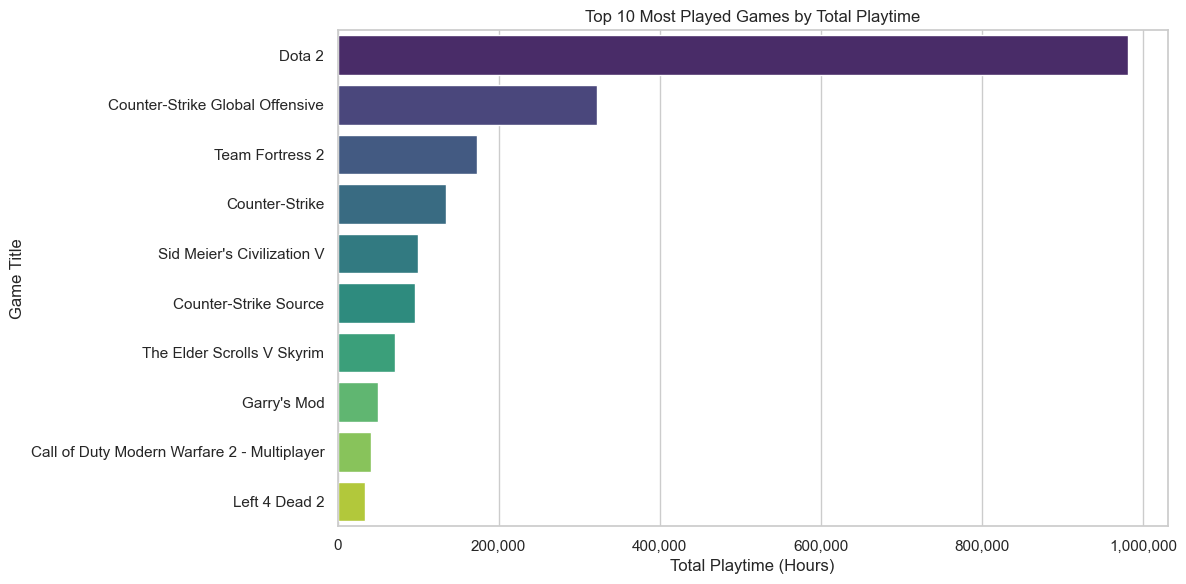

In [12]:
import matplotlib.ticker as ticker

top_games = df_play.groupby('game_title')['value'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=top_games.values, y=top_games.index, palette='viridis')
plt.title('Top 10 Most Played Games by Total Playtime')
plt.xlabel('Total Playtime (Hours)')
plt.ylabel('Game Title')

# Disable scientific notation on the x-axis
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.tight_layout()
plt.show()

### 2.3 Top 10 Most Interacted Games (by Number of Plays) --> Item Popularity

This plot ranks games by how many users interacted with them — a different view of popularity than total hour.


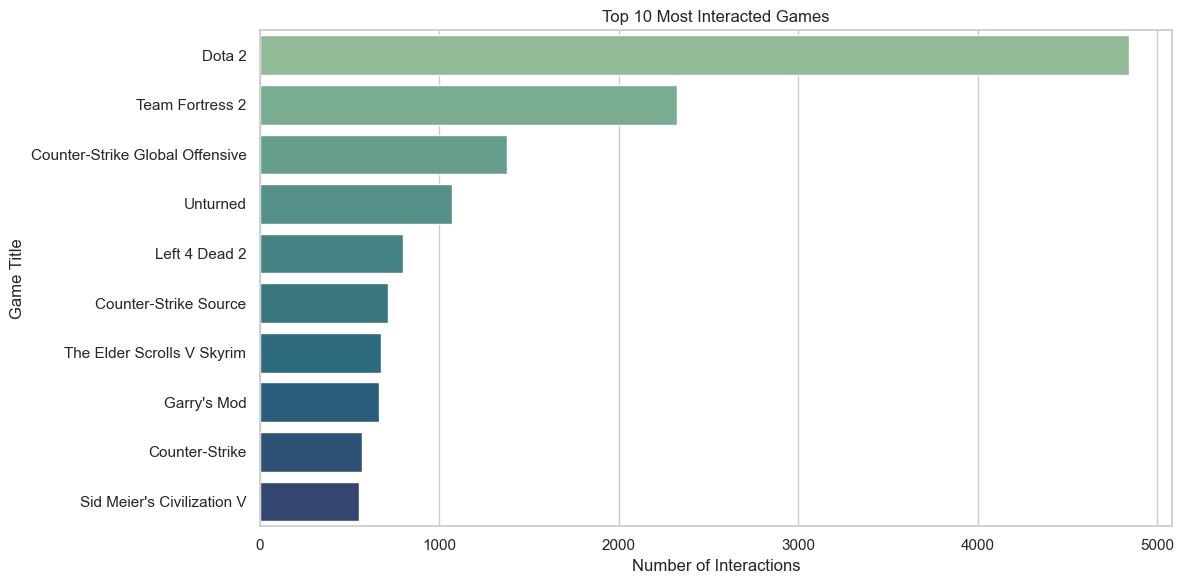

In [13]:
most_played_games = df_play['game_title'].value_counts().head(10)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=most_played_games.values, y=most_played_games.index, palette='crest')
plt.title('Top 10 Most Interacted Games')
plt.xlabel('Number of Interactions')
plt.ylabel('Game Title')

plt.tight_layout()
plt.show()

### 2.4 Top 10 Most Active Users (Total Playtime)  --> User Behavior

This plot highlights users who played the most total hours across all game.


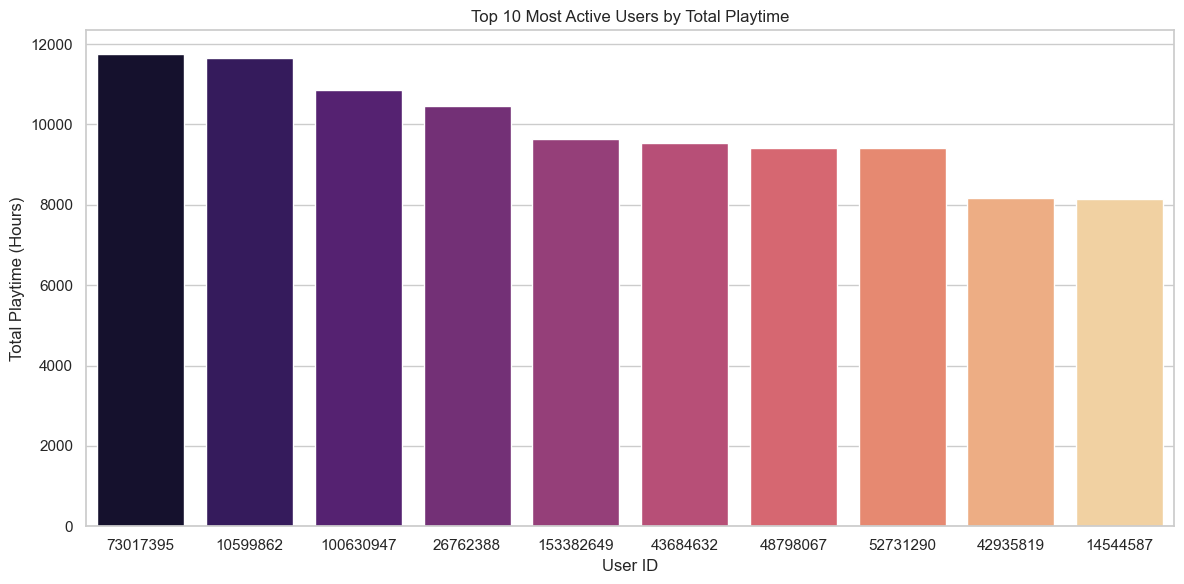

In [14]:
top_users = df_play.groupby('user_id')['value'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=top_users.index.astype(str), y=top_users.values, palette='magma')
plt.title('Top 10 Most Active Users by Total Playtime')
plt.xlabel('User ID')
plt.ylabel('Total Playtime (Hours)')

plt.tight_layout()
plt.show()

### 2.5 Top 10 Most Active Users (by Number of Interactions) --> User Behavior

This shows users who interacted with the largest number of game.


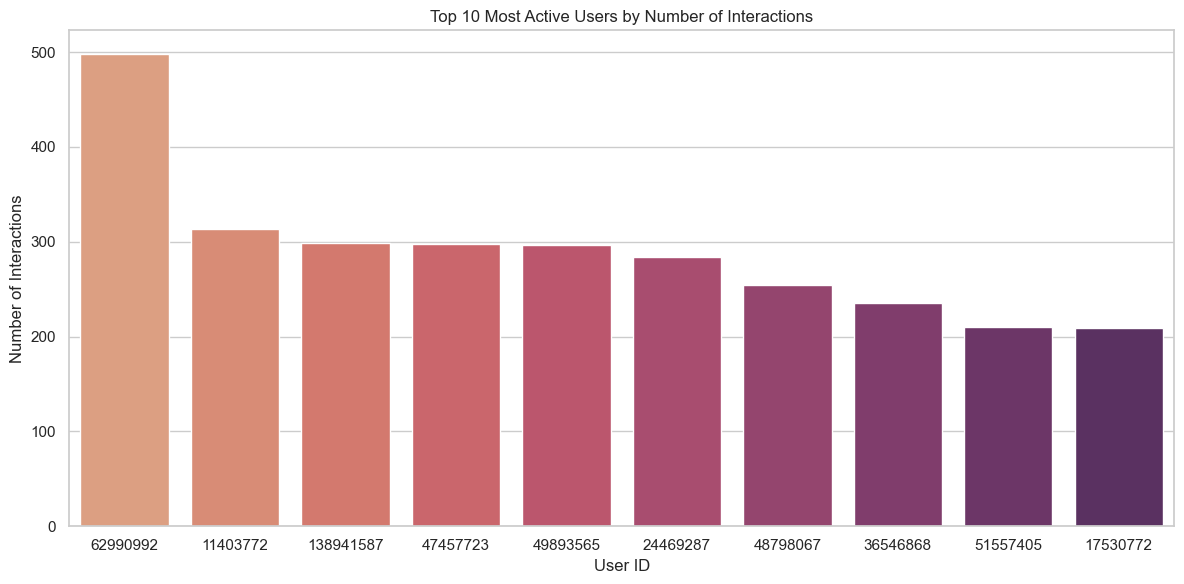

In [15]:
most_active_users = df_play['user_id'].value_counts().head(10)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=most_active_users.index.astype(str), y=most_active_users.values, palette='flare')
plt.title('Top 10 Most Active Users by Number of Interactions')
plt.xlabel('User ID')
plt.ylabel('Number of Interactions')

plt.tight_layout()
plt.show()

### 2.6 Distribution of Games Played per User --> User Behavior

This plot reveals how many games users typically play — a sign of their engagement range.

C:\Users\amarl\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


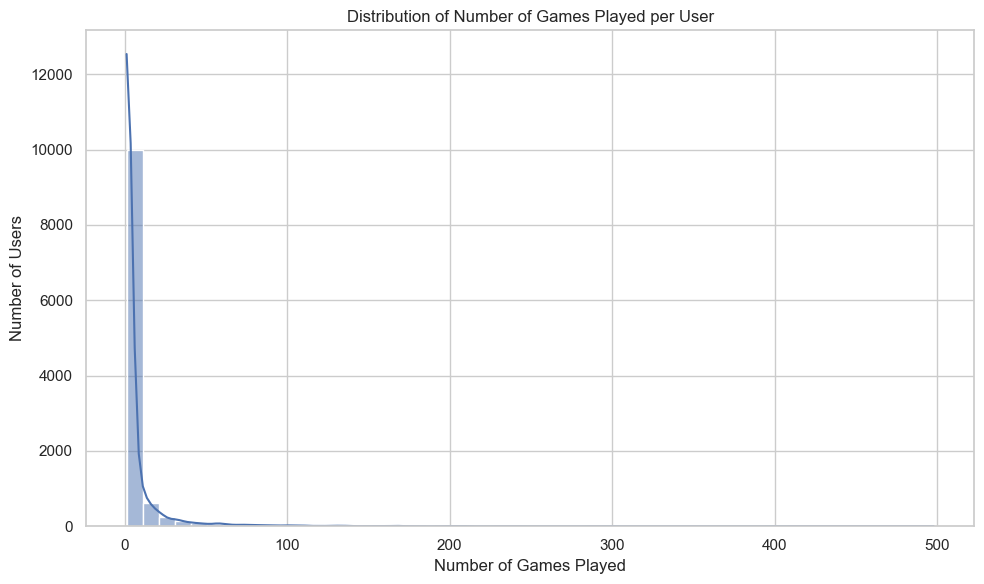

In [16]:
user_game_counts = df_play.groupby('user_id')['game_title'].nunique()

plt.figure(figsize=(10, 6))
sns.histplot(user_game_counts, bins=50, kde=True)
plt.title('Distribution of Number of Games Played per User')
plt.xlabel('Number of Games Played')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

### 2.7 Distribution of Number of Users per Game --> Item Popularity

This shows how many users have played each game — helps understand item popularity sprea.


C:\Users\amarl\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


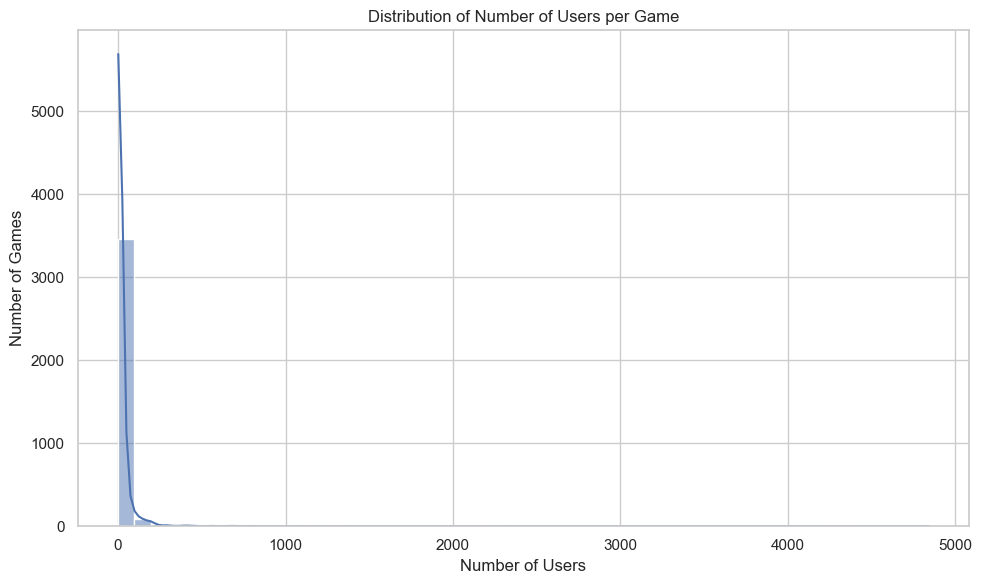

In [17]:
game_user_counts = df_play.groupby('game_title')['user_id'].nunique()

plt.figure(figsize=(10, 6))
sns.histplot(game_user_counts, bins=50, kde=True)
plt.title('Distribution of Number of Users per Game')
plt.xlabel('Number of Users')
plt.ylabel('Number of Games')
plt.tight_layout()
plt.show()

### 2.8 Top Games by Average Playtime --> Item Popularity

Games with the highest average time spent per user — a good signal of deep engagemen.


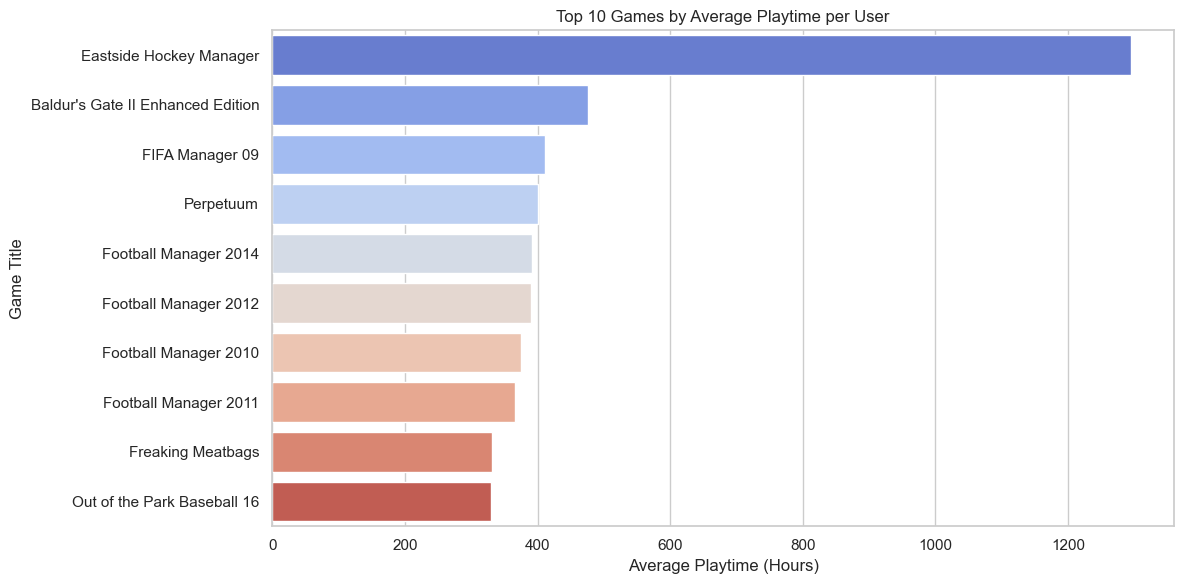

In [18]:
avg_playtime = df_play.groupby('game_title')['value'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=avg_playtime.values, y=avg_playtime.index, palette='coolwarm')
plt.title('Top 10 Games by Average Playtime per User')
plt.xlabel('Average Playtime (Hours)')
plt.ylabel('Game Title')

plt.tight_layout()
plt.show()

### 2.9 Correlation Heatmap of Numeric Features

To explore potential relationships between numeric variables in the dataset, a correlation heatmap was generated using the following features:  
- `value` (raw playtime in hours)  
- `playtime_normalized` (normalized playtime)  
- `user_encoded` (encoded user ID)  
- `game_encoded` (encoded game ID)  

As expected, `value` and `playtime_normalized` show a perfect correlation (1.00) since the latter is derived from the former. The remaining variables (`user_encoded` and `game_encoded`) show weak or no correlation with playtime values, as they are simply encoded categorical identifiers without inherent numerical meaning.

This analysis was conducted as part of exploratory efforts, but the heatmap was omitted from the final report due to minimal additional insight.


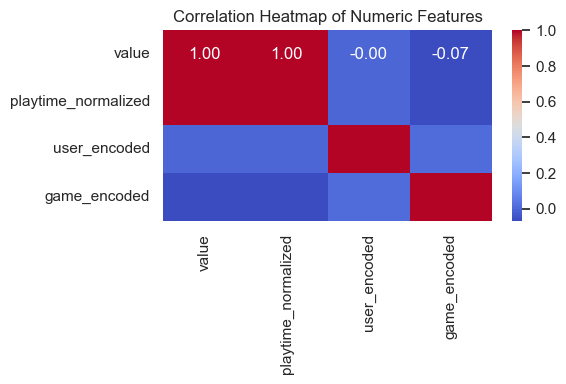

In [19]:
# Correlation heatmap
numeric_cols = ['value', 'playtime_normalized', 'user_encoded', 'game_encoded']
correlation_matrix = df_play[numeric_cols].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

### 2.10 Summary of EDA Insights

This exploratory analysis reveals several key patterns in the Steam dataset:
- **Playtime is heavily skewed**, with most users playing for short durations and a small group playing extensively.
- A few **games dominate in popularity**, both in total playtime and number of interactions.
- Some games show **high average playtime**, suggesting deep engagement.
- **User activity varies widely** — from casual to highly active users.
- **Item popularity is long-tailed**, with most games played by only a few users.

These insights guide our choice of models and evaluation metrics in the next phase.

## 3.0 Focus Item Summary

In [20]:
import pandas as pd

df_play = pd.read_csv("steam_cleaned_normalized_play.csv")

In [21]:
# Select top 5 games by total playtime
top_games_focus = df_play.groupby('game_title')['value'].sum().sort_values(ascending=False).head(5).index.tolist()

# Filter to only those top 5 games
focused_df = df_play[df_play['game_title'].isin(top_games_focus)]

# Aggregate metrics
summary = focused_df.groupby('game_title').agg(
    total_playtime=('value', 'sum'),
    average_playtime=('value', 'mean'),
    number_of_users=('user_id', 'nunique'),
    number_of_interactions=('user_id', 'count')
).reset_index()

# Compute playtime per interaction
summary['playtime_per_interaction'] = summary['total_playtime'] / summary['number_of_interactions']

# Display the result
summary

,game_title,total_playtime,average_playtime,number_of_users,number_of_interactions,playtime_per_interaction
0,Counter-Strike,134261.1,236.375176,568,568,236.375176
1,Counter-Strike Global Offensive,322771.6,234.402033,1377,1377,234.402033
2,Dota 2,981684.6,202.785499,4841,4841,202.785499
3,Sid Meier's Civilization V,99821.3,180.182852,554,554,180.182852
4,Team Fortress 2,173673.3,74.762505,2323,2323,74.762505


## 4.0 User-to-User Collaborative Filtering

In [22]:
# Remove rows where normalized playtime is zero (not useful for CF)
df_filtered = df_play[df_play['playtime_normalized'] > 0].copy()

In [23]:
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy

# Prepare data
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(df_filtered[['user_id', 'game_title', 'playtime_normalized']], reader)

# Split data
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Define User-User CF model
sim_options = {'name': 'cosine', 'user_based': True}
user_user_model = KNNBasic(sim_options=sim_options)
user_user_model.fit(trainset)

# Predict and evaluate
predictions = user_user_model.test(testset)
mae = accuracy.mae(predictions)
rmse = accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
MAE:  0.0053
RMSE: 0.0186


In [24]:
from collections import defaultdict
import numpy as np

# Function to get top-N recommendations per user
def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        top_n[uid] = sorted(user_ratings, key=lambda x: x[1], reverse=True)[:n]
    return top_n

# Function to build actual items played in test set (ground truth)
def get_actual_items(testset):
    actual = defaultdict(set)
    for uid, iid, true_r in testset:
        actual[uid].add(iid)
    return actual

# Calculate ranking metrics: Precision@K, MAP, MRR, NDCG
def evaluate_ranking(predictions, testset, k=10):
    top_n = get_top_n(predictions, n=k)
    actual_items = get_actual_items(testset)

    precisions, ap_scores, reciprocal_ranks, ndcgs = [], [], [], []

    for uid in actual_items:
        actual = actual_items[uid]
        if uid not in top_n:
            continue
        predicted = [iid for iid, _ in top_n[uid]]

        # Precision@K
        hits = [1 if iid in actual else 0 for iid in predicted]
        precisions.append(sum(hits) / k)

        # MAP
        score, num_hits = 0.0, 0
        for i, p in enumerate(predicted):
            if p in actual:
                num_hits += 1
                score += num_hits / (i + 1)
        ap_scores.append(score / max(len(actual), 1))

        # MRR
        rr = 0.0
        for i, p in enumerate(predicted):
            if p in actual:
                rr = 1 / (i + 1)
                break
        reciprocal_ranks.append(rr)

        # NDCG
        dcg = sum([1 / np.log2(i + 2) if predicted[i] in actual else 0 for i in range(len(predicted))])
        idcg = sum([1 / np.log2(i + 2) for i in range(min(len(actual), k))])
        ndcgs.append(dcg / idcg if idcg > 0 else 0)

    return {
        'Precision@K': np.mean(precisions),
        'MAP': np.mean(ap_scores),
        'MRR': np.mean(reciprocal_ranks),
        'NDCG': np.mean(ndcgs)
    }

# Run evaluation
ranking_results_user_user = evaluate_ranking(predictions, testset, k=10)
# Generate Top-N recommendations again outside the function
top_n = get_top_n(predictions, n=10)
ranking_results_user_user

{'Precision@K': 0.2533483146067416,
 'MAP': 0.9771457352086623,
 'MRR': 1.0,
 'NDCG': 1.0}

In [25]:
# Reuse the top_n generated earlier
from collections import Counter

# Check how many unique Top-N lists there are
all_recommendation_lists = [tuple(iid for iid, _ in items) for items in top_n.values()]
unique_lists = set(all_recommendation_lists)

print(f"Number of users evaluated: {len(top_n)}")
print(f"Number of unique recommendation lists: {len(unique_lists)}")

# Check 2 sample user
for i, (uid, items) in enumerate(top_n.items()):
    print(f"\nUser {uid} recommendations:")
    for rank, (iid, score) in enumerate(items, 1):
        print(f"  {rank}. {iid} (score: {score:.4f})")
    if i == 1:  # Show only 2 users
        break

Number of users evaluated: 4450
Number of unique recommendation lists: 2291

User 11373749 recommendations:
  1. Call of Duty Modern Warfare 2 - Multiplayer (score: 0.0133)
  2. Garry's Mod (score: 0.0123)
  3. Terraria (score: 0.0051)
  4. The Witcher 2 Assassins of Kings Enhanced Edition (score: 0.0020)
  5. Dishonored (score: 0.0019)
  6. Left 4 Dead 2 (score: 0.0017)
  7. The Cave (score: 0.0017)
  8. Call of Duty Modern Warfare 2 (score: 0.0016)
  9. Watch_Dogs (score: 0.0016)
  10. Game Dev Tycoon (score: 0.0008)

User 66255019 recommendations:
  1. ARK Survival Evolved (score: 0.0054)
  2. Assassin's Creed IV Black Flag (score: 0.0052)
  3. Blood Bowl 2 (score: 0.0048)
  4. Fallout New Vegas (score: 0.0044)
  5. Necronomicon The Dawning of Darkness (score: 0.0043)
  6. EVE Online (score: 0.0034)
  7. Fable III (score: 0.0030)
  8. Magic 2015 (score: 0.0025)
  9. Assassin's Creed II (score: 0.0024)
  10. FINAL FANTASY VII (score: 0.0022)


## 5.0 Item-Item Collaborative Filtering

This section implements an **Item-Item Collaborative Filtering** model using cosine similarity. Instead of comparing users, the model identifies similarities between items (games) based on shared user interactions. It is particularly effective in sparse datasets where users have limited overlap.

In [26]:
from surprise import KNNBasic, accuracy

# Define item-based collaborative filtering (cosine similarity)
sim_options = {
    'name': 'cosine',
    'user_based': False  # Set to False for item-item
}

item_item_model = KNNBasic(sim_options=sim_options)
item_item_model.fit(trainset)

# Predict on test set
predictions_item_item = item_item_model.test(testset)

# Evaluate MAE and RMSE
mae_item = accuracy.mae(predictions_item_item)
rmse_item = accuracy.rmse(predictions_item_item)

Computing the cosine similarity matrix...
Done computing similarity matrix.
MAE:  0.0060
RMSE: 0.0207


In [27]:
from collections import defaultdict
import numpy as np

def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        top_n[uid] = sorted(user_ratings, key=lambda x: x[1], reverse=True)[:n]
    return top_n

def get_actual_items(testset):
    actual = defaultdict(set)
    for uid, iid, true_r in testset:
        actual[uid].add(iid)
    return actual

def evaluate_ranking(predictions, testset, k=10):
    top_n = get_top_n(predictions, n=k)
    actual_items = get_actual_items(testset)

    precisions, ap_scores, reciprocal_ranks, ndcgs = [], [], [], []

    for uid in actual_items:
        actual = actual_items[uid]
        if uid not in top_n:
            continue
        predicted = [iid for iid, _ in top_n[uid]]

        # Precision@K
        hits = [1 if iid in actual else 0 for iid in predicted]
        precisions.append(sum(hits) / k)

        # MAP
        score, num_hits = 0.0, 0
        for i, p in enumerate(predicted):
            if p in actual:
                num_hits += 1
                score += num_hits / (i + 1)
        ap_scores.append(score / max(len(actual), 1))

        # MRR
        rr = 0.0
        for i, p in enumerate(predicted):
            if p in actual:
                rr = 1 / (i + 1)
                break
        reciprocal_ranks.append(rr)

        # NDCG
        dcg = sum([1 / np.log2(i + 2) if predicted[i] in actual else 0 for i in range(len(predicted))])
        idcg = sum([1 / np.log2(i + 2) for i in range(min(len(actual), k))])
        ndcgs.append(dcg / idcg if idcg > 0 else 0)

    return {
        'Precision@K': np.mean(precisions),
        'MAP': np.mean(ap_scores),
        'MRR': np.mean(reciprocal_ranks),
        'NDCG': np.mean(ndcgs)
    }

In [28]:
# Generate ranking metrics for item-item model
ranking_results_item_item = evaluate_ranking(predictions_item_item, testset, k=10)
ranking_results_item_item

{'Precision@K': 0.2533483146067416,
 'MAP': 0.9771457352086623,
 'MRR': 1.0,
 'NDCG': 1.0}

In [29]:
# Generate top_n again for item-item CF
top_n = get_top_n(predictions_item_item, n=10)

# Check how many unique recommendation lists there are
all_recommendation_lists = [tuple(iid for iid, _ in items) for items in top_n.values()]
unique_lists = set(all_recommendation_lists)

print(f"Number of users evaluated: {len(top_n)}")
print(f"Number of unique recommendation lists: {len(unique_lists)}")

# Show recommendations for 2 sample users
for i, (uid, items) in enumerate(top_n.items()):
    print(f"\nUser {uid} recommendations:")
    for rank, (iid, score) in enumerate(items, 1):
        print(f"  {rank}. {iid} (score: {score:.4f})")
    if i == 1:
        break

Number of users evaluated: 4450
Number of unique recommendation lists: 2307

User 11373749 recommendations:
  1. The Beginner's Guide (score: 0.0062)
  2. Tales of Monkey Island Chapter 3 - Lair of the Leviathan  (score: 0.0051)
  3. Tales of Monkey Island Chapter 2 - The Siege of Spinner Cay  (score: 0.0044)
  4. Time Gentlemen, Please! (score: 0.0041)
  5. ibb & obb (score: 0.0039)
  6. Spectraball (score: 0.0038)
  7. Windosill (score: 0.0037)
  8. Nightmares from the Deep The Cursed Heart (score: 0.0032)
  9. Sam & Max 104 Abe Lincoln Must Die! (score: 0.0032)
  10. Obulis (score: 0.0032)

User 66255019 recommendations:
  1. Necronomicon The Dawning of Darkness (score: 0.0043)
  2. Risen 3 - Titan Lords (score: 0.0041)
  3. Blood Bowl 2 (score: 0.0037)
  4. Magic 2015 (score: 0.0027)
  5. FINAL FANTASY VII (score: 0.0026)
  6. Fallout New Vegas (score: 0.0024)
  7. FTL Faster Than Light (score: 0.0024)
  8. BioShock (score: 0.0024)
  9. Assassins Creed Unity (score: 0.0024)
  10. F

## 6.0 Content-Based Filtering

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Get back training data as DataFrame
train_df = pd.DataFrame(trainset.build_testset(), columns=["user_id", "game_title", "playtime_normalized"])

# Build user profile
user_histories = train_df.groupby("user_id")["game_title"].apply(lambda x: sorted(set(x))).to_dict()

# Use TF-IDF on game titles (or replace with tags if available)
unique_games = df[['game_title']].drop_duplicates().reset_index(drop=True)
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(unique_games['game_title'])

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
game_indices = pd.Series(unique_games.index, index=unique_games['game_title']).drop_duplicates()

def get_content_recommendations(game_title, top_n=10):
    idx = game_indices.get(game_title)
    if idx is None:
        return []
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    return [(unique_games['game_title'][i], score) for i, score in sim_scores]

# Generate predictions for each user in testset
test_users = set([uid for (uid, _, _) in testset])
test_df = pd.DataFrame(testset, columns=["user_id", "game_title", "playtime_normalized"])

predictions_cb = []

for uid in test_users:
    if uid not in user_histories:
        continue
    liked_games = user_histories[uid]
    scores = defaultdict(float)

    for game in liked_games:
        similar_games = get_content_recommendations(game, top_n=20)
        for sim_game, sim_score in similar_games:
            if sim_game in liked_games:
                continue
            scores[sim_game] += sim_score

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]
    actual_items = set(test_df[test_df['user_id'] == uid]['game_title'])

    for game_title, score in ranked:
        true_r = 1 if game_title in actual_items else 0
        predictions_cb.append((uid, game_title, true_r, score, None))

# Ranking evaluation
def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        top_n[uid] = sorted(user_ratings, key=lambda x: x[1], reverse=True)[:n]
    return top_n

def get_actual_items(testset):
    actual = defaultdict(set)
    for uid, iid, true_r, *_ in testset:
        actual[uid].add(iid)
    return actual

def evaluate_ranking(predictions, testset, k=10):
    top_n = get_top_n(predictions, n=k)
    actual_items = get_actual_items(testset)

    precisions, ap_scores, reciprocal_ranks, ndcgs = [], [], [], []

    for uid in actual_items:
        actual = actual_items[uid]
        if uid not in top_n:
            continue
        predicted = [iid for iid, _ in top_n[uid]]

        # Precision@K
        hits = [1 if iid in actual else 0 for iid in predicted]
        precisions.append(sum(hits) / k)

        # MAP
        score, num_hits = 0.0, 0
        for i, p in enumerate(predicted):
            if p in actual:
                num_hits += 1
                score += num_hits / (i + 1)
        ap_scores.append(score / max(len(actual), 1))

        # MRR
        rr = 0.0
        for i, p in enumerate(predicted):
            if p in actual:
                rr = 1 / (i + 1)
                break
        reciprocal_ranks.append(rr)

        # NDCG
        dcg = sum([1 / np.log2(i + 2) if predicted[i] in actual else 0 for i in range(len(predicted))])
        idcg = sum([1 / np.log2(i + 2) for i in range(min(len(actual), k))])
        ndcgs.append(dcg / idcg if idcg > 0 else 0)

    return {
        'Precision@K': np.mean(precisions),
        'MAP': np.mean(ap_scores),
        'MRR': np.mean(reciprocal_ranks),
        'NDCG': np.mean(ndcgs)
    }

In [31]:
# Evaluate
ranking_results_cb = evaluate_ranking(predictions_cb, testset, k=10)
print("Content-Based Recommender Ranking Metrics:")
print(ranking_results_cb)

Content-Based Recommender Ranking Metrics:
{'Precision@K': 0.028847413228552717, 'MAP': 0.06081065497733535, 'MRR': 0.11021351129406139, 'NDCG': 0.09111193177302282}


In [33]:
def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        top_n[uid] = sorted(user_ratings, key=lambda x: x[1], reverse=True)[:n]
    return top_n

# Generate top_n from  existing predictions_cb
top_n_cb = get_top_n(predictions_cb, n=10)

# Check how many unique recommendation lists there are
all_recommendation_lists_cb = [tuple(iid for iid, _ in items) for items in top_n_cb.values()]
unique_lists_cb = set(all_recommendation_lists_cb)

print(f"Number of users evaluated: {len(top_n_cb)}")
print(f"Number of unique recommendation lists: {len(unique_lists_cb)}")

# Show recommendations for 2 sample users
for i, (uid, items) in enumerate(top_n_cb.items()):
    print(f"\nUser {uid} recommendations:")
    for rank, (iid, score) in enumerate(items, 1):
        print(f"  {rank}. {iid} (score: {score:.4f})")
    if i == 1:
        break

Number of users evaluated: 3054
Number of unique recommendation lists: 2561

User 33300480 recommendations:
  1. Portal 2 - The Final Hours (score: 0.5761)
  2. Portal Stories Mel (score: 0.5210)
  3. Portal 2 Sixense MotionPack (score: 0.5149)
  4. Portal 2 Sixense Perceptual Pack (score: 0.4920)
  5. Pinball FX2 - Portal  Pinball (score: 0.4612)
  6. Portal of Evil Stolen Runes Collector's Edition (score: 0.4147)
  7. The Elder Scrolls V Skyrim (score: 0.0000)
  8. Fallout 4 (score: 0.0000)
  9. Spore (score: 0.0000)
  10. Fallout New Vegas (score: 0.0000)

User 25337857 recommendations:
  1. Counter-Strike (score: 1.8659)
  2. Counter-Strike Source (score: 1.8476)
  3. Counter-Strike Condition Zero (score: 1.6890)
  4. Killing Floor 2 (score: 1.6099)
  5. Half-Life Deathmatch Source (score: 1.6002)
  6. Counter-Strike Nexon Zombies - Starter Pack (score: 1.5829)
  7. Half-Life Source (score: 1.4909)
  8. Half-Life 2 (score: 1.4363)
  9. Half-Life (score: 1.4363)
  10. Killing Floor 